# NB2: Choosing and Training a Model

## Constructing a basic linear model

So far we have peeked at the data and applied two scaling techniques. Let's construct a very basic model to predict precursor at t+n where t is the previous timestep and n represent the lead time. Lead time being t_delta between observation and prediction.

For our model we are give a matrix of predictors **X** and a vector of **y**. We are trying to solve for model *w* which minimizes the following:

$$\text{min}||Xw-y||^2 $$

There will me more on this later. Let's just abstract away model building for now so we can see the importance of feature scaling and normalization.

The general steps here will be.

*Step 1*: Build X and y

*Step 2*: Separate data into a training set, valuation set, and test set. (There is a bit of technique in this, but we will make this simple for now.)

*Step 3*: Use the training set to develop a model that will generalize to the valuation set. 

*Step 4*: Apply changes as necessary to avoid underfitting and overfitting. (More on this later.)

*Step 5*: Apply your model to the test set.

### Helper

In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
import os
import yaml
import copy
import torch
import pickle
import logging
import traceback
import numpy as np
import pandas as pd
import tensorflow as tf
import multiprocessing as mp
import matplotlib.pyplot as plt
import s3fs

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
sys.path.append("/glade/work/schreck/repos/GECKO_OPT/clean/gecko-ml")
# from geckoml.models import DenseNeuralNetwork, GRUNet
from geckoml.metrics import *
from geckoml.data import *
#from geckoml.box import *

from scipy.stats import pearsonr
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

import tqdm
from sklearn.base import BaseEstimator, TransformerMixin
%matplotlib inline

In [2]:
class IdentityTransformer(TransformerMixin,BaseEstimator):    
    def __init__(self):
        pass
    
    def fit(self, input_array, y=None):
        return self
    
    def transform(self, input_array, y=None):
        return input_array.to_numpy()
    
    def inverse_transform(self,X, copy=None):
        return X

In [3]:
with open("/glade/u/home/ochaarawi/toluene_agg.yml") as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)

In [63]:
# Extract config arguments and validate if necessary
species = config['species']
dir_path = config['dir_path']
summary_file = config['summary_file']
aggregate_bins = config['aggregate_bins']
bin_prefix = config['bin_prefix']
input_vars = config['input_vars']
output_vars = config['output_vars']
output_path = config['output_path']
scaler_type = config['scaler_type']
seq_length = config['seq_length']
ensemble_members = config["ensemble_members"]
seed = config['random_seed']
# tf.random.set_seed(seed)

for folder in ['models', 'plots', 'validation_data', 'metrics', 'scalers']:
    os.makedirs(join(output_path, folder), exist_ok=True)

# Load GECKO experiment data, split into ML inputs and outputs and persistence outputs
input_data, output_data = combine_data(dir_path, summary_file, aggregate_bins, bin_prefix,
                                       input_vars, output_vars, species)

# inverse log transform precursor data
input_data = inverse_log_transform(input_data, 'Precursor [ug/m3]')
output_data = inverse_log_transform(output_data, 'Precursor [ug/m3]')

Saved input and output data as a parquet for quick access.

In [64]:
# input_data.to_parquet("/glade/work/ochaarawi/Notebook_2_data/toluene_input_data_agg.parquet")
# output_data.to_parquet("/glade/work/ochaarawi/Notebook_2_data/toluene_output_data_agg.parquet")

In [4]:
input_data = pd.read_parquet("/glade/work/ochaarawi/Notebook_2_data/toluene_input_data_agg.parquet")
output_data = pd.read_parquet("/glade/work/ochaarawi/Notebook_2_data/toluene_output_data_agg.parquet")

In [5]:
# Split into training, validation, testing subsets
in_train, out_train, in_val, out_val, in_test, out_test = split_data(
                                                                input_data=input_data, 
                                                                output_data=output_data, 
                                                                train_start=config['train_start_exp'],
                                                                train_end=config['train_end_exp'],
                                                                val_start=config['val_start_exp'],
                                                                val_end=config['val_end_exp'],
                                                                test_start=config['test_start_exp'],
                                                                test_end=config['test_end_exp'])

In [6]:
num_timesteps = in_train['Time [s]'].nunique()

In [7]:
# Rescale training and validation / testing data
x_scaler = IdentityTransformer()
scaled_in_train = x_scaler.fit_transform(in_train.drop(['Time [s]', 'id'], axis=1))
scaled_in_val = x_scaler.transform(in_val.drop(['Time [s]', 'id'], axis=1))

y_scaler = x_scaler
scaled_out_train = y_scaler.transform(out_train.drop(['Time [s]', 'id'], axis=1))
scaled_out_val = y_scaler.transform(out_val.drop(['Time [s]', 'id'], axis=1))

# scaled_in_train_ts, scaled_out_train_ts = reshape_data(scaled_in_train.copy(), scaled_out_train.copy(),
#                                                        seq_length, num_timesteps)
# scaled_in_val_ts, scaled_out_val_ts = reshape_data(scaled_in_val.copy(), scaled_out_val.copy(),
#                                                    seq_length, num_timesteps)

In [8]:
# toluene
tolu_keras_mlp = "/glade/work/keelyl/geckonew/gecko-ml/toluene_agg_runs_unvaried/4_27_models/toluene_dnn_1_6/"
tolu_torch_rnn = "/glade/work/schreck/repos/GECKO_OPT/gecko-ml/echo/toluene/6/best.pt"

# apin
apin_keras_mlp = "/glade/work/keelyl/geckonew/gecko-ml/apin_agg_runs/05_14_models/apin_O3_dnn_1_2/"
apin_torch_rnn = "/glade/work/schreck/repos/GECKO_OPT/gecko-ml/echo/apin/7/best.pt"

# dodecane
dode_keras_mlp = "/glade/work/keelyl/geckonew/gecko-ml/dodecane_agg_runs/05_06_models/dodecane_dnn_1_6/"
dode_torch_rnn = "/glade/work/schreck/repos/GECKO_OPT/gecko-ml/echo/dodecane/3/best.pt"

In [9]:
species = "toluene"

In [10]:
if species == "toluene":
    keras_mlp = tolu_keras_mlp
    torch_rnn = tolu_torch_rnn
    prec_lim = 0.05
    gas_lim = 0.0275
    aero_lim = 0.008
elif species == "dodecane":
    keras_mlp = dode_keras_mlp
    torch_rnn = dode_torch_rnn
    prec_lim = 0.075
    gas_lim = 0.1
    aero_lim = 0.08
else:
    keras_mlp = apin_keras_mlp
    torch_rnn = apin_torch_rnn
    prec_lim = 0.075
    gas_lim = 0.1
    aero_lim = 0.07
    
fontsize = 14

In [11]:
# Batch the training experiments 
#logging.info("Batching the training data by experiment, this may take a few minutes")
def work(exp):
    in_data = x_scaler.transform(in_train[in_train['id'] == exp].iloc[:, 1:-1])
    env_conds = in_data[0, -6:]
    return (np.expand_dims(in_data, axis=0), np.expand_dims(env_conds, axis=0))
train_exps = list(in_train['id'].unique())
with mp.Pool(processes=8) as p:
    in_array, env_array = zip(*[result for result in tqdm.tqdm(p.imap(work, train_exps), total=len(train_exps))])
#in_array, env_array = zip(*[work(x) for x in train_exps])
in_array = np.concatenate(in_array) # (num_experiments, num_timesteps, outputs)
env_array = np.concatenate(env_array)

100%|██████████| 1600/1600 [00:21<00:00, 75.98it/s]


In [32]:
#logging.info("Batching the validation data by experiment")
def work(exp):
    in_data = x_scaler.transform(in_val[in_val['id'] == exp].iloc[:, 1:-1])
    env_conds = in_data[0, -6:]
    return (np.expand_dims(in_data, axis=0), np.expand_dims(env_conds, axis=0))
val_exps = list(in_val['id'].unique())
val_in_array, val_env_array = zip(*[work(x) for x in tqdm.tqdm(val_exps)])
val_in_array = np.concatenate(val_in_array) # (num_experiments, num_timesteps, outputs)
val_env_array = np.concatenate(val_env_array)

  0%|          | 0/200 [00:00<?, ?it/s]

NameError: name 'x_scaler' is not defined

In [113]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
lin_model.fit(scaled_in_train, scaled_out_train)

LinearRegression()

In [120]:
import compare_models
import numpy as np

In [121]:
lin_mae, truth, preds, failed_exps = compare_models.box_val(
    lin_model, 
    val_exps, 
    num_timesteps, 
    val_in_array, 
    val_env_array, 
    y_scaler, 
    output_vars, 
    out_val
)

100%|██████████| 1438/1438 [00:00<00:00, 13077.13it/s]


ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

In [117]:
mean_absolute_error??

Signature:
mean_absolute_error(
    y_true,
    y_pred,
    *,
    sample_weight=None,
    multioutput='uniform_average',
)
Source:   
@_deprecate_positional_args
def mean_absolute_error(y_true, y_pred, *,
                        sample_weight=None,
                        multioutput='uniform_average'):
    """Mean absolute error regression loss.

    Read more in the :ref:`User Guide <mean_absolute_error>`.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Ground truth (correct) target values.

    y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated target values.

    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.

    multioutput : {'raw_values', 'uniform_average'}  or array-like of shape \
            (n_outputs,), default='uniform_average'
        Defines aggregating of multiple output values.
        Array-like value defines weights used to avera

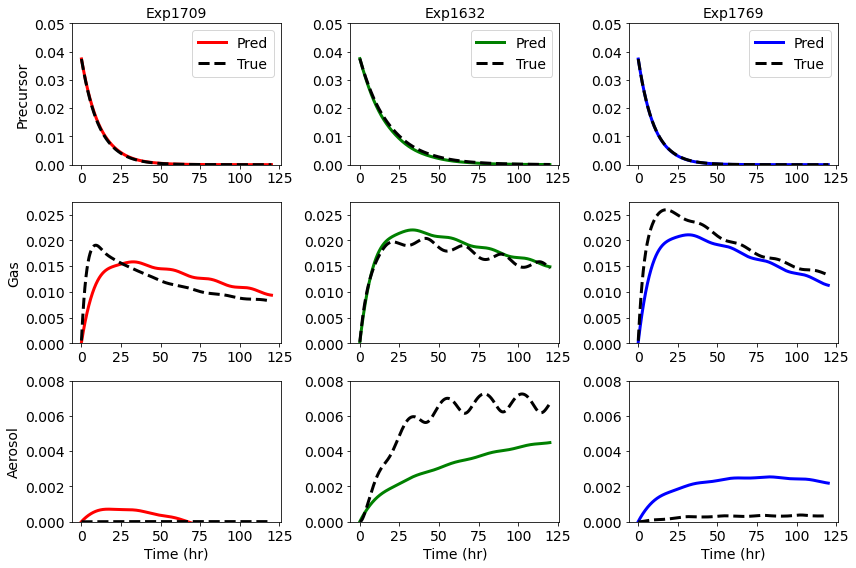

In [122]:
compare_models.plot(truth, preds, fontsize, prec_lim, gas_lim, aero_lim)

In [5]:
test.foo("hello")

hello


In [67]:
toluene_train = pd.read_csv('/glade/scratch/cbecker/gecko_data/toluene_train_in_binned.csv')

In [68]:
toluene_test = pd.read_csv('/glade/scratch/cbecker/gecko_data/toluene_val_in_binned.csv')

In [69]:
toluene_train['Precursor [ug/m3]'] = 10**toluene_train['Precursor [ug/m3]']
toluene_test['Precursor [ug/m3]'] = 10**toluene_test['Precursor [ug/m3]']

In [65]:
toluene_train.head()

,Time [s],Precursor [ug/m3],Gas [ug/m3] Bin01: lg(C*) = -6.5,Gas [ug/m3] Bin02: lg(C*) = -5.5,Gas [ug/m3] Bin03: lg(C*) = -4.5,Gas [ug/m3] Bin04: lg(C*) = -3.5,Gas [ug/m3] Bin05: lg(C*) = -2.5,Gas [ug/m3] Bin06: lg(C*) = -1.5,Gas [ug/m3] Bin07: lg(C*) = -0.5,Gas [ug/m3] Bin08: lg(C*) = 0.5,...,Aerosol [ug_m3] Bin12: lg(C*) = 4.5,Aerosol [ug_m3] Bin13: lg(C*) = 5.5,Aerosol [ug_m3] Bin14: lg(C*) = 6.5,temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),id
0,1.000000,0.037689,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,305.065364,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0
1,301.207794,0.037426,2.767639e-17,5.465436e-13,1.420820e-12,4.041857e-12,4.353356e-12,5.635269e-12,6.116312e-12,1.709608e-10,...,1.133111e-11,1.206304e-13,5.079438e-12,304.978044,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0
2,601.415588,0.037164,2.772026e-17,5.440976e-13,1.415403e-12,4.287764e-12,4.421259e-11,1.623398e-11,2.802625e-11,1.634808e-09,...,2.606058e-11,4.502163e-13,5.588369e-12,304.890766,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0
3,901.623352,0.036904,2.772170e-17,5.417454e-13,1.413397e-12,5.737255e-12,1.927043e-10,4.042448e-11,8.991534e-11,5.784281e-09,...,4.304783e-11,9.602400e-13,6.075447e-12,304.803571,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0
4,1201.831177,0.036646,2.803421e-17,5.397588e-13,1.422216e-12,1.059735e-11,5.276418e-10,8.292556e-11,2.145164e-10,1.374481e-08,...,6.160334e-11,1.625196e-12,6.543917e-12,304.716502,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0


In [2]:
def prepare_data(data, input_columns, output_columns):
    """ Splits data to input/output with corresponding lag """
    
    data['id'] = data['id'].apply(lambda x: int(x[3:])) # change expnumber to int for sorting
    data.index.name = 'indx'
    data = data.sort_values(['id','indx'])
    x_data = data[input_columns].iloc[:-1, :]
    y_data = data[output_columns].iloc[1:, :]
    
    return x_data, y_data

In [3]:
dataFrame = pd.read_parquet("/glade/work/ochaarawi/toluene_binned_data_post_processed_062921.parquet")

In [4]:
dataFrame.head()

,Time [s],Precursor [ug/m3],Temperature [K],OH [molec/cm3],O3 [molec/cm3],NOx [molec/cm3],SZA [degree],pre-existing aerosols (ug/m3),Gas [ug/m3] Bin01: lg(C*) = -6.5,Gas [ug/m3] Bin02: lg(C*) = -5.5,...,Aerosol [ug_m3] Bin06: lg(C*) = -1.5,Aerosol [ug_m3] Bin07: lg(C*) = -0.5,Aerosol [ug_m3] Bin08: lg(C*) = 0.5,Aerosol [ug_m3] Bin09: lg(C*) = 1.5,Aerosol [ug_m3] Bin10: lg(C*) = 2.5,Aerosol [ug_m3] Bin11: lg(C*) = 3.5,Aerosol [ug_m3] Bin12: lg(C*) = 4.5,Aerosol [ug_m3] Bin13: lg(C*) = 5.5,Aerosol [ug_m3] Bin14: lg(C*) = 6.5,id
0,1.000000,0.037689,305.065338,4259464.0,2.131903e+12,4.663982e+10,156.839686,0.019914,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Exp0
1,301.207794,0.037426,305.065338,4259464.0,2.131903e+12,3.089762e+11,156.845342,0.019914,2.767639e-17,5.465436e-13,...,9.054297e-15,9.536815e-15,1.136227e-13,2.032317e-13,1.340980e-11,2.885481e-13,1.133111e-11,1.206304e-13,5.079438e-12,Exp0
2,601.415588,0.037164,304.978027,4259464.0,2.131903e+12,3.365964e+11,156.787255,0.019914,2.772026e-17,5.440976e-13,...,5.943645e-14,7.428282e-14,1.512578e-12,9.430169e-13,8.381891e-11,7.481274e-13,2.606058e-11,4.502163e-13,5.588369e-12,Exp0
3,901.623352,0.036904,304.890747,4259464.0,2.131903e+12,3.391282e+11,156.665902,0.019914,2.772170e-17,5.417454e-13,...,1.997679e-13,3.134865e-13,6.184021e-12,2.238016e-12,2.204330e-10,1.405585e-12,4.304783e-11,9.602400e-13,6.075447e-12,Exp0
4,1201.831177,0.036646,304.803558,4259464.0,2.131903e+12,3.390159e+11,156.482265,0.019914,2.803421e-17,5.397588e-13,...,5.122663e-13,9.234878e-13,1.600177e-11,4.197395e-12,4.191702e-10,2.286769e-12,6.160334e-11,1.625196e-12,6.543917e-12,Exp0


Prepare data

### Training, validation, and testing sets
This training dataset/library consists of 2000 GECKO experiments, including results for 5 day runs (1440 timesteps at 300 second intervals). The data has already been split into training/validation/test sets by random expiriments of size 1400/200/200 (and 200 for a hidden test set). Thus, the training set consists of 2,016,000 samples of data and test/validation sets with 288,000 samples.